In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Create RDM codes for each condition
# Digit recognition code
dgt_cd = np.zeros((16,16))
dgt_cd[:10,:10] = 1

# Object recognition code
obj_cd = np.zeros((16,16))
obj_cd[10:,10:] = 1

# Digit vs. Object code
vs_cd = np.zeros((16,16))
vs_cd[:10,10:] = 1
vs_cd[10:,:10] = 1

# Magnitude code
mag_cd = np.zeros((16,16))
mag_cd[7:10,1:4] = 1

# Animacy code
ani_cd = np.zeros((16,16))
ani_cd[13:,10:13] = 1

cd_name_list = ['Digit', 'Object', 'Versus', 'Magnitude', 'Animacy']    
cds_list = [dgt_cd,obj_cd,vs_cd,mag_cd,ani_cd]
num_cds = len(cds_list)

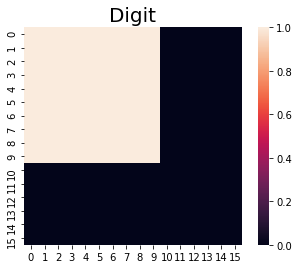

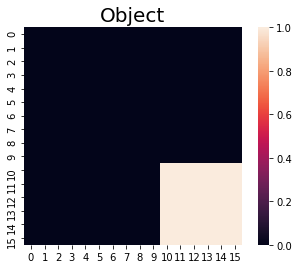

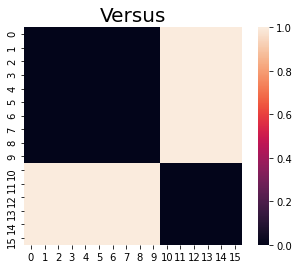

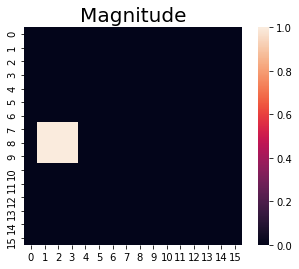

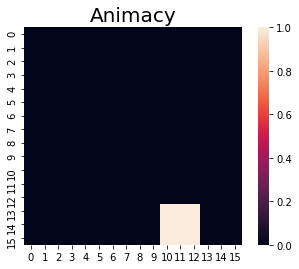

In [6]:
# Plot codes
for cdi in range(num_cds):
    f = plt.figure()
    plt.title(cd_name_list[cdi], fontsize=20)
    sns.heatmap(cds_list[cdi],square=True)
    plt.show()

In [7]:
# Define function
def rdm_reord(org):
    new = org.copy()
    new[10:15,10:15] = org[11:,11:]
    new[15,15] = org[10,10]
    new[-1,10:15] = org[10,11:]
    new[10:15,-1] = org[11:,10]
    return new

il16 = np.tril_indices(16,-1)
def rsa(rdm_,code):
    rho, p = stats.spearmanr(code[il16],rdm_[il16])
    return rho, p 

In [8]:
# Load sample neural RDM made by '03_MVPA_Neural_RDMs.ipynb'
l = np.load('Sample_Neural_RDM.npz',allow_pickle=True)
brain_rdm = l['rdm']
brain_inform_list = l['info_list']

# Number of searchlight voxels
nvv = brain_rdm.shape[0]

# RSA
rsa_rslt = np.zeros((num_cds,64,76,64))
rsa_rslt_pval = np.zeros((num_cds,64,76,64))
for cdi,code in enumerate(cds_list):
    vol_rho = np.zeros((64,76,64))
    vol_pval = np.zeros((64,76,64))
    for vi in range(nvv):
        idx = brain_inform_list[vi][1]
        rdm_ = rdm_reord(brain_rdm[vi])
        vol_rho[idx], vol_pval[idx] = rsa(rdm_,code)
    rsa_rslt[cdi], rsa_rslt_pval[cdi] = vol_rho, vol_pval

# ROI map associated with each concept

In [11]:
p_threshold = 0.05
rsa_rslt[(rsa_rslt_pval > p_threshold)] = 0 # uncorrected p-values used in this sample code
rsa_rslt[(rsa_rslt < 0)] = 0 # Positive voxels

In [ ]:
# If you want to save ROI map obtained from sample data, you can run this cell.
# Please set the path to save.
savedir = '/dir/to/save/'

import nibabel as nib

affine = np.array([[   3. ,   -0. ,   -0. ,  -94.5],
       [  -0. ,    3. ,   -0. , -130.5],
       [   0. ,    0. ,    3. ,  -76.5],
       [   0. ,    0. ,    0. ,    1. ]])

def save_nifti(vol, savepath, zero_to_nan=True):
    if zero_to_nan:
        vol[(vol==0)] = np.nan
    img1 = nib.Nifti1Image(vol,affine=affine)
    nib.save(img1,savepath)

for cdi in range(num_cds):    
    save_nifti(rsa_rslt[cdi], savedir+cd_name_list[cdi]+'.nii')